# 1- Class Activation Map with convolutions

In this firt part, we will code class activation map as described in the paper [Learning Deep Features for Discriminative Localization](http://cnnlocalization.csail.mit.edu/)

There is a GitHub repo associated with the paper:
https://github.com/zhoubolei/CAM

And even a demo in PyTorch:
https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py

The code below is adapted from this demo but we will not use hooks only convolutions...

In [1]:
import io
import requests
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
import cv2
import pdb
from matplotlib.pyplot import imshow


# input image
LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

As in the demo, we will use the Resnet18 architecture. In order to get CAM, we need to transform this network in a fully convolutional network: at all layers, we need to deal with images, i.e. with a shape $\text{Number of channels} \times W\times H$ . In particular, we are interested in the last images as shown here:
![](https://camo.githubusercontent.com/fb9a2d0813e5d530f49fa074c378cf83959346f7/687474703a2f2f636e6e6c6f63616c697a6174696f6e2e637361696c2e6d69742e6564752f6672616d65776f726b2e6a7067)

As we deal with a Resnet18 architecture, the image obtained before applying the `AdaptiveAvgPool2d` has size $512\times 7 \times 7$ if the input has size $3\times 224\times 224 $:
![resnet_Archi](https://pytorch.org/assets/images/resnet.png)

A- The first thing, you will need to do is 'removing' the last layers of the resnet18 model which are called `(avgpool)` and `(fc)`. Check that for an original image of size $3\times 224\times 224 $, you obtain an image of size $512\times 7\times 7$.

B- Then you need to retrieve the weights (and bias) of the `fc` layer, i.e. a matrix of size $1000\times 512$ transforming a vector of size 512 into a vector of size 1000 to make the prediction. Then you need to use these weights and bias to apply it pixelwise in order to transform your $512\times 7\times 7$ image into a $1000\times 7\times 7$ output (Hint: use a convolution). You can interpret this output as follows: `output[i,j,k]` is the logit for 'pixel' `[j,k]` for being of class `i`.

C- From this $1000\times 7\times 7$ output, check that you can retrieve the original output given by the `resnet18` by using an `AdaptiveAvgPool2d`. Can you understand why this is true?

D- In addition, you can construct the Class Activation Map. Draw the activation map for the class mountain bike, for the class lakeside.

## Validation:
1. make sure that when running your notebook, you display both CAM for the class mountain bike and for the class lakeside.
2. for question B above, what convolution did you use? Your answer, i.e. the name of the Pytorch layer with the correct parameters (in_channel,kernel...) here:
<span style="color:red">
conv = nn.Conv2d(512,1000,kernel_size=1,stride=1, padding=0)
The name of the PyTorch layer is "Conv2d"
The parameters are:
- in_channels: 512 (number of input channels)
- out_channels: 1000 (number of output channels)
- kernel_size: 1 (size of the convolving kernel)
- stride: 1 (the stride of the sliding window)
- padding: 0 (number of zero padding added to both sides of the input)
</span>



3. your short explanation of why your network gives the same predicition as the original `resnet18`:
<span style="color:red">
The network gives the same prediction as the original resnet18 because the weights and bias of the fc layer have been used in the new conv layer to transform the output. This means that the same mathematical operations that were used in the original resnet18 to make predictions are now being applied to the new logit_new output. Therefore, the new network will produce the same predictions as the original resnet18 because it uses the same weights and bias in its calculations.</span>

4. Is your network working on an image which is not of size $224\times 224$, i.e. without resizing? and what about `resnet18`? Explain why?

<span style="color:red">No, this network and the original resnet18 are not designed to work on an image which is not of size $224\times224$ without resizing. If an image of a different size is used as input, the first layer will not be able to extract features in the same way as it is designed to, and the subsequent layers will not be able to process the image correctly. This will result in incorrect predictions and errors in the network, so, it is necessary to resize an image to $224\times224$ before using it as input to the resnet18 network or the modified network created in the previous code.</span>

In [2]:
net = models.resnet18(pretrained=True)


/Users/alexandrefrancois/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alexandrefrancois/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
x = torch.randn(5, 3, 224, 224)
y = net(x)
y.shape

torch.Size([5, 1000])

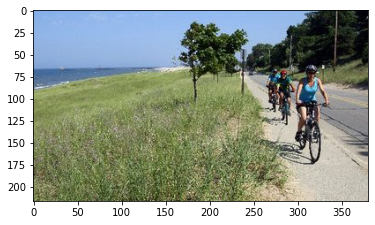

In [5]:
n_mean = [0.485, 0.456, 0.406]
n_std = [0.229, 0.224, 0.225]

normalize = transforms.Normalize(
   mean=n_mean,
   std=n_std
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

# Display the image we will use.
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
imshow(img_pil)

In [6]:
img_tensor = preprocess(img_pil)
net = net.eval()
logit = net(img_tensor.unsqueeze(0))

In [7]:
logit.shape

torch.Size([1, 1000])

In [8]:
img_tensor.shape

torch.Size([3, 224, 224])

In [9]:
# download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}


def print_preds(logit):
    # print the predicitions with their 'probabilities' from the logit
    h_x = F.softmax(logit, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    return idx

In [10]:
idx = print_preds(logit)


0.437 -> ['n03792782', 'mountain_bike']
0.131 -> ['n09193705', 'alp']
0.119 -> ['n02835271', 'bicycle-built-for-two']
0.108 -> ['n04509417', 'unicycle']
0.049 -> ['n09332890', 'lakeside']


In [11]:
def returnCAM(feature_conv, idx):
    # input: tensor feature_conv of dim 1000*W*H and idx between 0 and 999
    # output: image W*H with entries rescaled between 0 and 255 for the display
    cam = feature_conv[idx].detach().numpy()
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    return cam_img

In [12]:
#some utilities
def pil_2_np(img_pil):
    # transform a PIL image in a numpy array
    return np.asarray(img_pil)

def display_np(img_np):
    imshow(Image.fromarray(np.uint8(img_np)))
    
def plot_CAM(img_np, CAM):
    height, width, _ = img_np.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAM,(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + img_np * 0.5
    display_np(result)

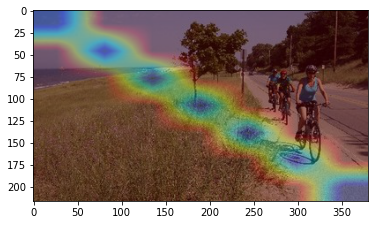

In [13]:
# here is a fake example to see how things work
img_np = pil_2_np(img_pil)
diag_CAM = returnCAM(torch.eye(7).unsqueeze(0),0)
plot_CAM(img_np,diag_CAM)

In [14]:
# your code here for your new network
# Remove the last two layers
net_conv = torch.nn.Sequential(*list(net.children())[:-2])

net_conv = net_conv.eval()

In [15]:
# to test things are right
x = torch.randn(5, 3, 224, 224)
y = net_conv(x)
y.shape

torch.Size([5, 512, 7, 7])

In [16]:
logit_conv = net_conv(img_tensor.unsqueeze(0))

In [17]:
logit_conv.shape

torch.Size([1, 512, 7, 7])

In [18]:

# #Retrieve the weights and bias from the fc layer
# fc = list(net.children())[-1]
# fc_weights = fc.weight.data
# fc_bias = fc.bias.data

# # Create a convolution layer with the fc weights and bias
# conv = torch.nn.Conv2d(512, 1000, 1, bias=False)
# conv.weight = torch.nn.Parameter(fc_weights.unsqueeze(-1).unsqueeze(-1))
# conv.bias = torch.nn.Parameter(fc_bias)

# #Apply the convolution
# logit_new = conv(logit_conv)

# #Use AdaptiveAvgPool2d to reduce the size to [1,1000]
# avg_pool = torch.nn.AdaptiveAvgPool2d((1,1))
# logit_new = avg_pool(logit_new)
# logit_new = logit_new.view(1,-1)

# #Final shape of logit_new should be [1,1000]

# print(logit_new.shape) # Output: torch.Size([1, 1000])




In [19]:
# First the convolution
conv=nn.Conv2d(512,1000,kernel_size=1,stride=1, padding=0)
conv.weight.data=net.fc.weight.data.unsqueeze(-1).unsqueeze(-1)
conv.bias=net.fc.bias

#Apply the convolution
logit_conv=conv(logit_conv)
logit_conv.shape

# transfor this to a [1,1000] tensor with AdaptiveAvgPool2d
logit_new = net.avgpool(logit_conv).squeeze(-1).squeeze(-1)
logit_new.shape

torch.Size([1, 1000])

In [20]:
idx = print_preds(logit_new)

0.437 -> ['n03792782', 'mountain_bike']
0.131 -> ['n09193705', 'alp']
0.119 -> ['n02835271', 'bicycle-built-for-two']
0.108 -> ['n04509417', 'unicycle']
0.049 -> ['n09332890', 'lakeside']


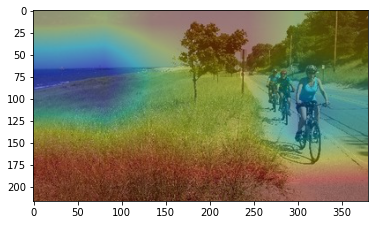

In [21]:
i = 4  #index of lakeside
CAM1 = returnCAM(logit_conv.squeeze(),idx[i])
plot_CAM(img_np,CAM1)

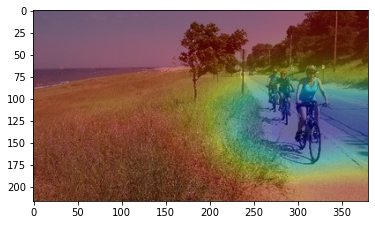

In [22]:
i = 0 #index of mountain bike
CAM2 = returnCAM(logit_conv.squeeze(),idx[i])
plot_CAM(img_np,CAM2)

# 2- Adversarial examples

In this second part, we will look at [adversarial examples](https://arxiv.org/abs/1607.02533): "An adversarial example is a sample of input data which has been modified very slightly in a way that is intended to cause a machine learning classifier to misclassify it. In many cases, these modifications can be so subtle that a human observer does not even notice the modification at all, yet the classifier still makes a mistake. Adversarial examples pose security concerns because they could be used to perform an attack on machine learning systems..."

Rules of the game:
- the attacker cannot modify the classifier, i.e. the neural net with the preprocessing done on the image before being fed to the network. 
- even if the attacker cannot modifiy the classifier, we assume that the attacker knows the architecture of the classifier. Here, we will still work with `resnet18` and the standard Imagenet normalization. 
- the attacker can only modify the physical image fed into the network.
- the attacker should fool the classifier, i.e. the label obtained on the corrupted image should not be the same as the label predicted on the original image.

First, you will implement *Fast gradient sign method (FGSM)* wich is described in Section 2.1 of [Adversarial examples in the physical world](https://arxiv.org/abs/1607.02533). The idea is simple, suppose you have an image $\mathbf{x}$ and when you pass it through the network, you get the 'true' label $y$. You know that your network has been trained by minimizing the loss $J(\mathbf{\theta}, \mathbf{x}, y)$ with respect to the parameters of the network $\theta$. Now, $\theta$ is fixed as you cannot modify the classifier so you need to modify $\mathbf{x}$. In order to do so, you can compute the gradient of the loss with respect to $\mathbf{x}$ i.e. $\nabla_{\mathbf{x}} J(\mathbf{\theta}, \mathbf{x}, y)$ and use it as follows to get the modified image $\tilde{\mathbf{x}}$:
$$
\tilde{\mathbf{x}} = \text{Clamp}\left(\mathbf{x} + \epsilon *
\text{sign}(\nabla_{\mathbf{x}} J(\mathbf{\theta}, \mathbf{x}, y)),0,1\right),
$$
where $\text{Clamp}(\cdot, 0,1)$ ensures that $\tilde{\mathbf{x}}$ is a proper image.
Note that if instead of sign, you take the full gradient, you are now following the gradient i.e. increasing the loss $J(\mathbf{\theta}, \mathbf{x}, y)$ so that $y$ becomes less likely to be the predicited label.

## Validation:
1. Implement this attack. Make sure to display the corrupted image.

2. For what value of epsilon is your attack successful? What is the predicited class then?

<span style="color:red">For epsilon = 0.2 it preditcs ['Pomeranian';'hay';'briard';'chow';'racer']</span>

3. plot the sign of the gradient and pass this image through the network. What prediction do you obtain? Compare to [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) 

<span style="color:red">We obtained ['honeycomb''nematode''microphone''strainer''matchstick']. The gradient sign plot is very similar to the one presented in the paper, and we also find the nematode class as the 2nd most likely in our case. </span>

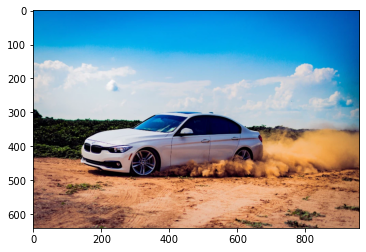

In [23]:
# Image under attack!
url_car = 'https://cdn130.picsart.com/263132982003202.jpg?type=webp&to=min&r=640'
response = requests.get(url_car)
img_pil = Image.open(io.BytesIO(response.content))
imshow(img_pil)

In [24]:
# same as above
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

for p in net.parameters():
    p.requires_grad = False
    
x = preprocess(img_pil).clone().unsqueeze(0)
logit = net(x)

In [25]:
_ = print_preds(logit)

0.639 -> ['n03770679', 'minivan']
0.065 -> ['n03594945', 'jeep']
0.039 -> ['n02814533', 'beach_wagon']
0.028 -> ['n02974003', 'car_wheel']
0.016 -> ['n03930630', 'pickup']


In [26]:
t_std = torch.from_numpy(np.array(n_std, dtype=np.float32)).view(-1, 1, 1)
t_mean = torch.from_numpy(np.array(n_mean, dtype=np.float32)).view(-1, 1, 1)

def plot_img_tensor(img):
    imshow(np.transpose(img.detach().numpy(), [1,2,0]))

def plot_untransform(x_t): 
    x_np = (x_t * t_std + t_mean).detach().numpy()
    x_np = np.transpose(x_np, [1, 2, 0])
    imshow(x_np)

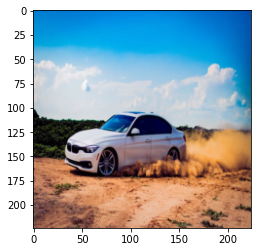

In [27]:
# here we display an image given as a tensor
x_img = (x * t_std + t_mean).squeeze(0)
plot_img_tensor(x_img)

In [28]:
# your implementation of the attack
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = np.sign(data_grad)

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    # perturbed_image = np.clip(perturbed_image, 0, 1)
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [29]:
idx = 656 #minivan
criterion = nn.CrossEntropyLoss()
x_img.requires_grad = True
logit = net(normalize(x_img).unsqueeze(0))
target = torch.tensor([idx])
loss = criterion(logit, target)
loss.backward()
_ = print_preds(logit)

0.639 -> ['n03770679', 'minivan']
0.065 -> ['n03594945', 'jeep']
0.039 -> ['n02814533', 'beach_wagon']
0.028 -> ['n02974003', 'car_wheel']
0.016 -> ['n03930630', 'pickup']


In [30]:
# your attack here
epsilon = 0.02
x_att = fgsm_attack(x_img, epsilon, x_img.grad)

In [31]:
# the new prediction for the corrupted image
logit = net(normalize(x_att).unsqueeze(0))
_ = print_preds(logit)

0.135 -> ['n02112018', 'Pomeranian']
0.098 -> ['n07802026', 'hay']
0.042 -> ['n02105251', 'briard']
0.042 -> ['n02112137', 'chow']
0.033 -> ['n04037443', 'racer']


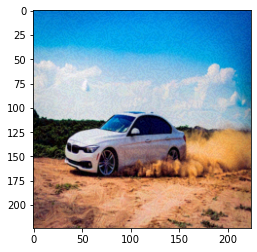

In [32]:
# can you see the difference?
plot_img_tensor(x_att)

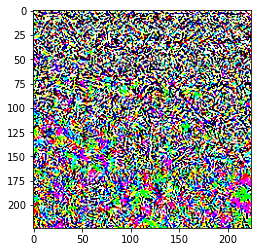

In [33]:
# do not forget to plot the sign of the gradient
gradient = x_img.grad.data.sign()
plot_img_tensor((1+gradient)/2)

In [34]:
# what is the prediction for the gradient? 
logit = net(normalize(gradient).unsqueeze(0))
_ = print_preds(logit)

0.580 -> ['n03530642', 'honeycomb']
0.322 -> ['n01930112', 'nematode']
0.087 -> ['n03759954', 'microphone']
0.003 -> ['n04332243', 'strainer']
0.002 -> ['n03729826', 'matchstick']


# 3- Transforming a car into a cat

We now implement the *Iterative Target Class Method (ITCM)* as defined by equation (4) in [Adversarial Attacks and Defences Competition](https://arxiv.org/abs/1804.00097)

To test it, we will transform the car (labeled minivan by our `resnet18`) into a [Tabby cat](https://en.wikipedia.org/wiki/Tabby_cat) (classe 281 in Imagenet). But you can try with any other target.

## Validation:
1. Implement the ITCM and make sure to display the resulting image. 

In [35]:
x = preprocess(img_pil).clone()
xd = preprocess(img_pil).clone()
xd.requires_grad = True


In [36]:
idx = 281 #tabby
optimizer = optim.SGD([xd], lr=0.01)

for i in range(200):
    # output = model(xd)
    # output = model(xd)
    # optimizer.zero_grad()
    # loss = F.cross_entropy(output, torch.tensor([idx]))
    # loss.backward()
    
    # xd.requires_grad = False
    # gradient = xd.grad.sign().detach()
    # # Add the gradient to the input
    # xd = xd + alpha * gradient
    # # Clip the perturbed input to be in the valid range [0, 1]
    # xd = torch.clamp(xd, 0, 1)
    # xd.requires_grad = True

    # # Pass the perturbed input through the model
    # output = model(xd)
    
    output=net(xd.unsqueeze(0))
    loss=criterion(output,torch.tensor([idx]))
   
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss.item())

    _ = print_preds(output)
    print(i,'-----------------')
    
    if output.argmax() == idx:
        break


11.433233261108398
0.639 -> ['n03770679', 'minivan']
0.065 -> ['n03594945', 'jeep']
0.039 -> ['n02814533', 'beach_wagon']
0.028 -> ['n02974003', 'car_wheel']
0.016 -> ['n03930630', 'pickup']
0 -----------------
11.12280559539795
0.610 -> ['n03770679', 'minivan']
0.064 -> ['n03594945', 'jeep']
0.039 -> ['n02814533', 'beach_wagon']
0.029 -> ['n02974003', 'car_wheel']
0.017 -> ['n03930630', 'pickup']
1 -----------------
10.823995590209961
0.579 -> ['n03770679', 'minivan']
0.063 -> ['n03594945', 'jeep']
0.039 -> ['n02814533', 'beach_wagon']
0.031 -> ['n02974003', 'car_wheel']
0.018 -> ['n03792972', 'mountain_tent']
2 -----------------
10.516989707946777
0.545 -> ['n03770679', 'minivan']
0.061 -> ['n03594945', 'jeep']
0.038 -> ['n02814533', 'beach_wagon']
0.032 -> ['n02974003', 'car_wheel']
0.020 -> ['n03792972', 'mountain_tent']
3 -----------------
10.220616340637207
0.509 -> ['n03770679', 'minivan']
0.059 -> ['n03594945', 'jeep']
0.037 -> ['n02814533', 'beach_wagon']
0.033 -> ['n02974003'

6.002688407897949
0.057 -> ['n03770679', 'minivan']
0.042 -> ['n02112350', 'keeshond']
0.038 -> ['n02112018', 'Pomeranian']
0.027 -> ['n04008634', 'projectile']
0.026 -> ['n02109961', 'Eskimo_dog']
41 -----------------
5.940334796905518
0.055 -> ['n03770679', 'minivan']
0.042 -> ['n02112350', 'keeshond']
0.038 -> ['n02112018', 'Pomeranian']
0.027 -> ['n04008634', 'projectile']
0.027 -> ['n02109961', 'Eskimo_dog']
42 -----------------
5.877459526062012
0.053 -> ['n03770679', 'minivan']
0.042 -> ['n02112350', 'keeshond']
0.039 -> ['n02112018', 'Pomeranian']
0.027 -> ['n04008634', 'projectile']
0.027 -> ['n02109961', 'Eskimo_dog']
43 -----------------
5.815655708312988
0.051 -> ['n03770679', 'minivan']
0.042 -> ['n02112350', 'keeshond']
0.039 -> ['n02112018', 'Pomeranian']
0.027 -> ['n02109961', 'Eskimo_dog']
0.027 -> ['n04008634', 'projectile']
44 -----------------
5.754611015319824
0.050 -> ['n03770679', 'minivan']
0.042 -> ['n02112350', 'keeshond']
0.039 -> ['n02112018', 'Pomeranian']


3.742399215698242
0.036 -> ['n02109961', 'Eskimo_dog']
0.032 -> ['n02110063', 'malamute']
0.028 -> ['n02112350', 'keeshond']
0.027 -> ['n02112018', 'Pomeranian']
0.025 -> ['n02091467', 'Norwegian_elkhound']
80 -----------------
3.6765666007995605
0.036 -> ['n02109961', 'Eskimo_dog']
0.032 -> ['n02110063', 'malamute']
0.028 -> ['n02112350', 'keeshond']
0.026 -> ['n02112018', 'Pomeranian']
0.025 -> ['n02123045', 'tabby']
81 -----------------
3.6106300354003906
0.036 -> ['n02109961', 'Eskimo_dog']
0.032 -> ['n02110063', 'malamute']
0.027 -> ['n02112350', 'keeshond']
0.027 -> ['n02123045', 'tabby']
0.026 -> ['n02112018', 'Pomeranian']
82 -----------------
3.5447232723236084
0.036 -> ['n02109961', 'Eskimo_dog']
0.032 -> ['n02110063', 'malamute']
0.029 -> ['n02123045', 'tabby']
0.027 -> ['n02112350', 'keeshond']
0.025 -> ['n02112018', 'Pomeranian']
83 -----------------
3.481208324432373
0.036 -> ['n02109961', 'Eskimo_dog']
0.032 -> ['n02110063', 'malamute']
0.031 -> ['n02123045', 'tabby']
0.

In [37]:
_ = print_preds(output)

0.037 -> ['n02123045', 'tabby']
0.036 -> ['n02109961', 'Eskimo_dog']
0.032 -> ['n02110063', 'malamute']
0.025 -> ['n02112350', 'keeshond']
0.024 -> ['n02091467', 'Norwegian_elkhound']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


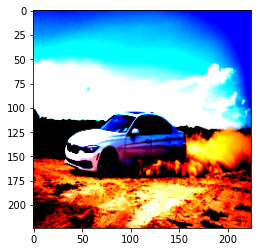

In [38]:
# plot the corrupted image -> I did not understand which image you want me to plot
# plot_img_tensor(xd.squeeze(0))
plot_img_tensor(x.squeeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


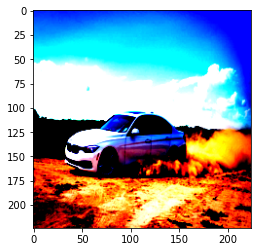

In [39]:
plot_img_tensor(xd.squeeze(0))

# 4- Where is the cat hidden?

Last, we use CAM to understand where the network see a cat in the image.

## Validation:
1. display the CAM for the class tabby

2. display the CAM for the class minivan

3. where is the cat? <span style="color:red">
The cat is behind the car, in the smoke.
</span>


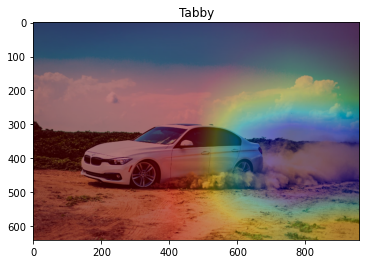

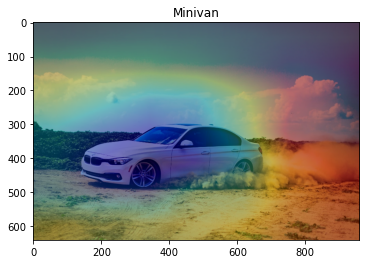

In [40]:
import matplotlib.pyplot as plt

logit_conv = net_conv(xd.unsqueeze(0))
logit_afterconv=conv(logit_conv).squeeze()
CAM_tabby=returnCAM(logit_afterconv,281)
CAM_minivan = returnCAM(logit_afterconv,656)
img_np=pil_2_np(img_pil)

plot_CAM(img_np,CAM_tabby)
plt.title('Tabby')
plt.show()
plot_CAM(img_np,CAM_minivan)
plt.title('Minivan')
plt.show()